# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Importing Libraries

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#imports to help me plot my venn diagrams
import matplotlib_venn as venn2
from matplotlib_venn import venn2
from pylab import rcParams

# import the util.py file where I define my functions
from utils import *

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
'''
There are 2 warnings when we read in the datasets:
DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
interactivity=interactivity, compiler=compiler, result=result)

This warning happens when pandas attempts to guess datatypes on particular columns, I will address this on 
the pre-processing steps
'''
azdias = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\azdias.csv")
customers = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\customers.csv")
attributes = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\features.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# I will now check what is the problem with the columns 19 and 20
# getting the name of these columns
print(azdias.iloc[:,19:21].columns)
print(customers.iloc[:,19:21].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [4]:
# checking the unique values in these columns for possible issues
print(azdias.CAMEO_DEUG_2015.unique())
print(azdias.CAMEO_INTL_2015.unique())
print(customers.CAMEO_DEUG_2015.unique())
print(customers.CAMEO_INTL_2015.unique())

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']


It seems like the mixed type issue comes from that  X that appears in these columns.
There are ints, floats and strings all in the mix

In [5]:
cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
azdias = mixed_type_fixer(azdias, cols)
customers = mixed_type_fixer(customers, cols)

#### Checking if values were fixed
#### Change this cell to code if you want to perform the checks

azdias.CAMEO_DEUG_2015.unique()
customers.CAMEO_INTL_2015.unique()

Considering the appearance of these mixed type data entries I created a function to check the dtype of the different attributes

This might be useful in case some attributes have too many category values, which might fragment the data clustering too much.

In [6]:
#doing a quick check of categorical features and see if some are too granular to be maintained
tst = categorical_checker(azdias, attributes)

AGER_TYP                      5
ANREDE_KZ                     2
CAMEO_DEU_2015               45
CAMEO_DEUG_2015               9
CJT_GESAMTTYP                 6
D19_BANKEN_DATUM             10
D19_BANKEN_OFFLINE_DATUM     10
D19_BANKEN_ONLINE_DATUM      10
D19_GESAMT_DATUM             10
D19_GESAMT_OFFLINE_DATUM     10
D19_GESAMT_ONLINE_DATUM      10
D19_KONSUMTYP                 7
D19_TELKO_DATUM              10
D19_TELKO_OFFLINE_DATUM      10
D19_TELKO_ONLINE_DATUM       10
D19_VERSAND_DATUM            10
D19_VERSAND_OFFLINE_DATUM    10
D19_VERSAND_ONLINE_DATUM     10
D19_VERSI_DATUM              10
D19_VERSI_OFFLINE_DATUM      10
D19_VERSI_ONLINE_DATUM       10
FINANZTYP                     6
GEBAEUDETYP                   7
GFK_URLAUBERTYP              12
GREEN_AVANTGARDE              2
KBA05_BAUMAX                  6
KK_KUNDENTYP                  6
LP_FAMILIE_FEIN              12
LP_FAMILIE_GROB               6
LP_STATUS_FEIN               10
LP_STATUS_GROB                5
NATIONAL

Based on the categorical info it might be a good idea do drop CAMEO_DEU_2015 column, it is far too fragmented with 45 different category values, this is an idea to revisit after testing the models

There is an extra column called Unnamed that seems like an index duplication, I will now drop it

In [7]:
#dropping unnamed column
azdias = azdias.drop(azdias.columns[0], axis = 1)
customers = customers.drop(customers.columns[0], axis = 1)

We also have 3 columns that are different between azdias and customers:

'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

I will drop those to harmonize the 2 datasets

In [8]:
customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)

#### I will now check overal shapes of the datasets

#### Azdias Shape

In [9]:
# checking how the azdias dataframe looks like
print('Printing dataframe shape')
print(azdias.shape)
print('________________________________________________________')

azdias.head()

Printing dataframe shape
(891221, 366)
________________________________________________________


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### Customers Shape

In [10]:
# checking how the customer dataframe looks like
print('Printing dataframe shape')
print(customers.shape)
print('________________________________________________________')

customers.head()

Printing dataframe shape
(191652, 366)
________________________________________________________


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


#### Attributes shape

In [11]:
# Check the summary csv file
print(attributes.shape)
attributes.head()

(332, 5)


,attribute,information_level,type,missing_or_unknown,Comment
0,AGER_TYP,person,categorical,"[-1,0]",NaN
1,ALTER_HH,household,interval,[0],NaN
2,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",NaN
3,ANREDE_KZ,person,categorical,"[-1,0]",NaN
4,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],NaN


### On the dataframe shapes:

#### For now it is noted that the 2 initial working dataframes are harmonized in terms of  number of columns:
#### azdias: (891221, 366)
#### customers: (191652, 366)
#### attributes: (332, 5)

In [12]:
#saving the unique attribute names to lists
attributes_list = attributes.attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [13]:
#establishing uniqueness of the attributes accross the datasets in work
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))

print("No of items common to all 3 daframes: " + str(len(common_to_all)))
print("No of items exclusive to azdias: " + str(len(unique_to_azdias)))
print("No of items exclusive to customers: " + str(len(unique_to_customers)))
print("No of items exclusive to attributes: " + str(len(unique_to_attributes)))
print("No of items overlapping between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of items exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
print("No of items exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of items common to all 3 daframes: 327
No of items exclusive to azdias: 0
No of items exclusive to customers: 0
No of items exclusive to attributes: 5
No of items overlapping between azdias and attributes: 327
No of items exclusive to attributes vs azdias: 5
No of items exclusive to azdias vs attributes: 5


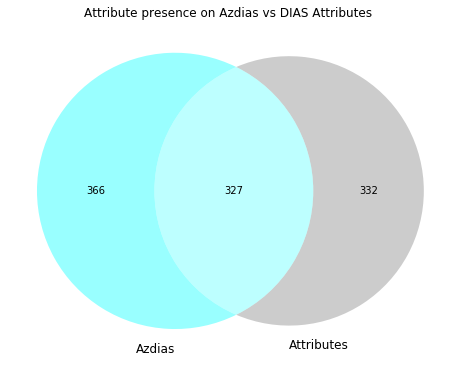

In [14]:
rcParams['figure.figsize'] = 8, 8

ax = plt.axes()
ax.set_facecolor('lightgrey')
v = venn2([len(azdias_list), len(attributes_list), len(common_azdias_attributes)], 
      set_labels=('Azdias', 'Attributes'),
         set_colors = ['cyan', 'grey']);

plt.title("Attribute presence on Azdias vs DIAS Attributes ")
plt.show()

### From this little exploration we got quite a little bit of information:
#### - There are 3 extra features in the customers dataset, it corresponds to the columns 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

#### - All the datasets share 327 features between them

#### - The attributes file has 5 columns corresponding to feature information that does not exist in the other datasets

## Preprocessing
### Now that I have a birds-eye view of the data I will proceed with cleaning and handling missing calues, re-encode features (since the first portion of this project will involve unsupervised learning), perform some feature enginnering and scaling.

### Assessing missing data and replacing it with nan
### Before dealing with the missing and unknown data I will save a copy of the dataframes for the purpose of visualizing how much improvement was achieved

In [15]:
#making dataframes copies pre-cleanup
azdias_pre_cleanup = azdias.copy()
customers_pre_cleanup = customers.copy()

In [16]:
# I am using feat_fixer to use the information in the attributes dataframe to fill the information 
# regarding missing and unknown values
azdias = feat_fixer(azdias, attributes)
customers = feat_fixer(customers, attributes)

### Since the net step involves dropping columns missing data over a threshold it is important to check if there is a column match between azdias and customers before and after the cleanup process

### There is a chance that some columns are missing too much data in one dataframe and being dropped while they are abundant in the other, causing a discrepancy in the shape between the 2 dataframes

#### It is always hard to define a threshold on how much missing data is too much, my first approach will consider over 30% too much
#### Based on model performance this is an idea to revisit and adjust

In [17]:
balance_checker(azdias, customers)

Feature balance between dfs?:  True


#### Prior to cleanup customers and azdias match

In [18]:
percent_missing_azdias_df = percentage_of_missing(azdias)
percent_missing_azdias_pc_df = percentage_of_missing(azdias_pre_cleanup)

percent_missing_customers_df = percentage_of_missing(customers)
percent_missing_customers_pc_df = percentage_of_missing(customers_pre_cleanup)

In [19]:
print('Identified missing data in Azdias: ')
print('Pre-cleanup: ' + str(azdias_pre_cleanup.isnull().sum().sum()) + ' Post_cleanup: ' + str(azdias.isnull().sum().sum()))

print('Identified missing data in Customers: ')
print('Pre-cleanup: ' + str(customers_pre_cleanup.isnull().sum().sum()) + ' Post_cleanup: ' + str(customers.isnull().sum().sum()))

Identified missing data in Azdias: 
Pre-cleanup: 33493669 Post_cleanup: 38930528
Identified missing data in Customers: 
Pre-cleanup: 13864774 Post_cleanup: 14809972


In [20]:
print('Azdias columns not missing values(percentage):')
print('Pre-cleanup: ', (percent_missing_azdias_df['percent_missing'] == 0.0).sum())
print('Post-cleanup: ', (percent_missing_azdias_pc_df['percent_missing'] == 0.0).sum())

print('Customers columns not missing values(percentage):')
print('Pre-cleanup: ', (percent_missing_customers_df['percent_missing'] == 0.0).sum())
print('Post-cleanup: ', (percent_missing_customers_pc_df['percent_missing'] == 0.0).sum())

Azdias columns not missing values(percentage):
Pre-cleanup:  88
Post-cleanup:  93
Customers columns not missing values(percentage):
Pre-cleanup:  88
Post-cleanup:  93


#### Deciding on what data to maintain based on the percentage missing

In [21]:
# missing more or less than 30% of the data
azdias_missing_over_30 = split_on_percentage(percent_missing_azdias_df, 30, '>')
azdias_missing_less_30 = split_on_percentage(percent_missing_azdias_df, 30, '<=')

customers_missing_over_30 = split_on_percentage(percent_missing_customers_df, 30, '>')
customers_missing_less_30 = split_on_percentage(percent_missing_customers_df, 30, '<=')

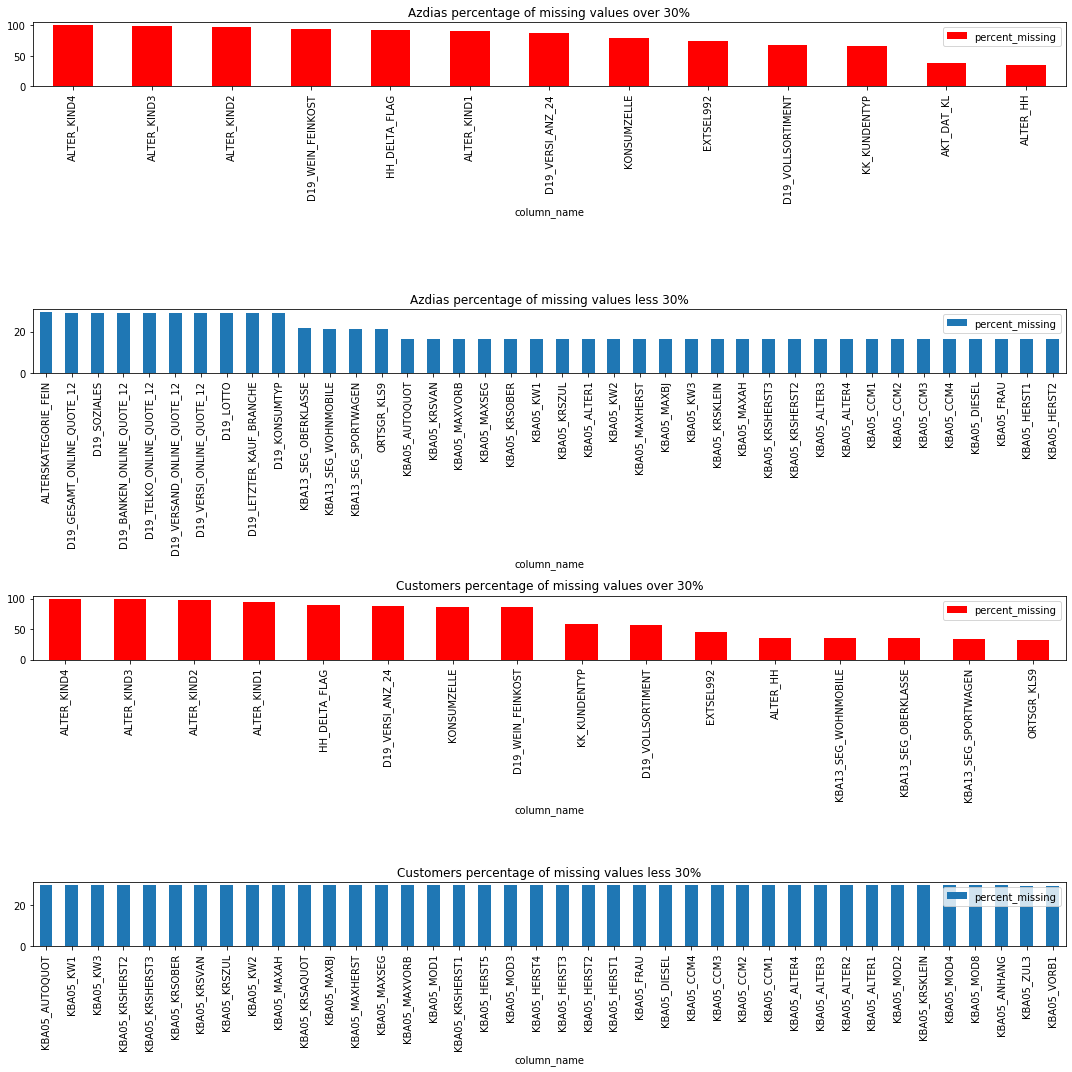

In [22]:
#plotting select features and their missing data percentages
figure, axes = plt.subplots(4, 1, figsize = (15,15), squeeze = False)

azdias_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[0][0], color = 'red', title = 'Azdias percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
azdias_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[1][0], title = 'Azdias percentage of missing values less 30%' )

customers_missing_over_30.sort_values(by = 'percent_missing', ascending = False).plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[2][0], color = 'red', title = 'Customers percentage of missing values over 30%' )

#due to the sheer amount of data points to be plotted this does not make an appealing vis so I will restrict
#the number of plotted points to 40
customers_missing_less_30.sort_values(by = 'percent_missing', ascending = False)[:40].plot(kind = 'bar', x = 'column_name', y = 'percent_missing',
                                                                                ax = axes[3][0], title = 'Customers percentage of missing values less 30%' )

plt.tight_layout()
plt.show()

### The vast majority of the columns with missing values have a percent of missing under 30%
### Based on this information I will remove columns with more than 30% missing values

In [23]:
#extracting column names with more than 30% values missing so we can drop them from azdias df
azdias_col_delete = columns_to_delete(azdias_missing_over_30)

#extracting column names with more than 30% values missing so we can drop them from customers df
customers_col_delete = columns_to_delete(customers_missing_over_30)

In [24]:
#dropping the columns identified in the previous lists

azdias = azdias.drop(azdias_col_delete, axis = 1)
customers = customers.drop(customers_col_delete, axis = 1)

### Now that we dropped columns missing more than 30% of their data let's check if we should also drop rows based on a particular threshold

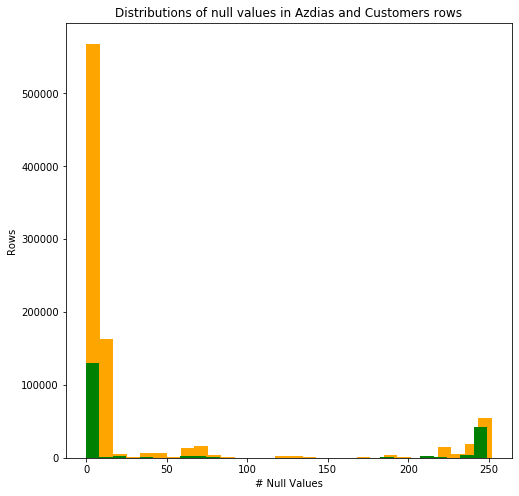

In [25]:
#plotting distribution of null values
row_hist(azdias, customers, 30)

#### Based on this visualization we deduct 2 things
##### - most of the rows are missing the information over less than 50 columns
##### - both customer and azdias have probably overlapping rows in which they are missing info corresponding to over 200 columns

In [26]:
#deleting rows based on the information acquired in the previous histogram 
azdias = row_dropper(azdias, 50)
customers = row_dropper(customers, 50)

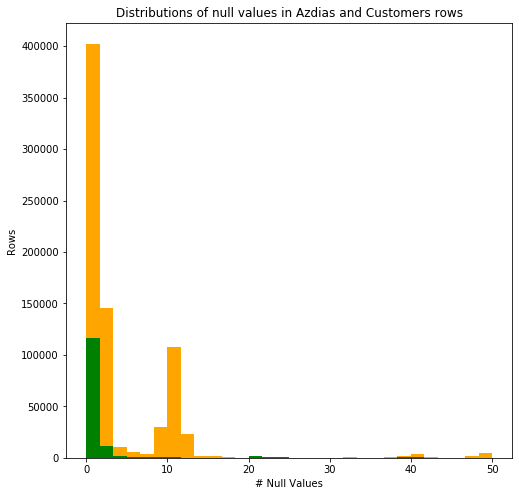

In [27]:
#plotting null values distribution after cleanup
row_hist(azdias, customers, 30)

In [28]:
balance_checker(azdias, customers)

Feature balance between dfs?:  False
Your first argument df differs from the second on the following columns: 
{'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_WOHNMOBILE', 'KBA13_SEG_SPORTWAGEN', 'ORTSGR_KLS9'}
Your second argument df differs from the first on the following columns: 
{'AKT_DAT_KL'}


In [29]:
azdias.shape

(750270, 353)

In [30]:
customers.shape

(135127, 350)

Based on this information the azdias df has a few columns extra when compared to customers:
- 'KBA13_SEG_WOHNMOBILE', 'ORTSGR_KLS9', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_OBERKLASSE'
-  These colummns refer to information on the type of car individuals own

The customers dataframe has a column not present in azdias: 
- 'AKT_DAT_KL'

So to finalize this step I will drop these columns

In [31]:
azdias = azdias.drop(['KBA13_SEG_WOHNMOBILE', 'ORTSGR_KLS9', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_OBERKLASSE'], inplace=False, axis=1)
customers = customers.drop(['AKT_DAT_KL'], inplace=False, axis=1)

In [32]:
balance_checker(azdias, customers)

Feature balance between dfs?:  True


## Feature Encoding

### Like I previously checked using the categorical_checker there are many features in need of re-encoding for the unsupervised learning portion 

- numerical features will be kept as is
- ordinal features will be kept as is
- categorical features and mixed type features will have to be re-encoded

In [33]:
#checking for mixed type features
attributes[attributes.type == 'mixed']

,attribute,information_level,type,missing_or_unknown,Comment
15,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]",NaN
286,LP_LEBENSPHASE_FEIN,person,mixed,[0],NaN
287,LP_LEBENSPHASE_GROB,person,mixed,[0],NaN
303,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]",NaN


In [34]:
#retrieve a list of categorical features for future encoding
cats = attributes[attributes.type == 'categorical']
list(cats['attribute'])

['AGER_TYP',
 'ANREDE_KZ',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_KONSUMTYP',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HAUSHALTSSTRUKTUR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'PLZ8_BAUMAX',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'WACHSTUMSGEBIET_NB',
 'WOHNLAGE',
 'ZABEOTYP']

#### At this point I already dealt with the CAMEO_INTL_2015 column by converting XX to nan

#### PRAEGENDE_JUGENDJAHRE has 3 dimentions: generation decade, if people are mainstream or avant-garde and if they are from east or west, I will create new features out of this particular column

#### LP_LEBENSPHASE_GROB seems to encode the same information as the CAMEO column and it is divided between gross(grob) and fine (fein) 

In [35]:
azdias = special_feature_handler(azdias)
customers = special_feature_handler(customers)

In [36]:
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE
0,8A,NaN
1,4C,D19_UNBEKANNT
2,2A,D19_UNBEKANNT
3,6B,D19_SCHUHE
4,8C,D19_ENERGIE


## Feature engineering
#### Based on the previous exploration there are a few features that are good candidates for novel feature creation

In [37]:
azdias_eng = azdias.copy()
customers_eng = customers.copy()
feat_eng(azdias_eng)
feat_eng(customers_eng)

,LNR,AGER_TYP,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,WOHNLAGE_QUALITY,WOHNLAGE_AREA,WEALTH,FAMILY,LP_LEBENSPHASE_FEIN_life_stage,LP_LEBENSPHASE_FEIN_fine_scale
0,9626,2.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,1,4,50.0,1.0,NaN,1.0,1.0,3.0,3.0,4.0
1,143872,-1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,2,4,50.0,1.0,2.0,0.0,3.0,4.0,3.0,4.0
2,143873,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,1,4,40.0,0.0,NaN,1.0,2.0,4.0,NaN,NaN
3,143874,-1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,1,3,70.0,0.0,3.0,0.0,4.0,1.0,3.0,1.0
4,143888,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,1,3,50.0,1.0,1.0,0.0,3.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135122,154561,1.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,1,3,50.0,1.0,1.0,0.0,1.0,4.0,NaN,NaN
135123,154563,-1.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,2,4,60.0,0.0,3.0,0.0,3.0,2.0,NaN,NaN
135124,148813,2.0,10.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,...,1,4,50.0,1.0,3.0,0.0,2.0,4.0,4.0,4.0
135125,148852,3.0,13.0,4.0,0.0,0.0,4.0,3.0,0.0,3.0,...,2,3,70.0,0.0,2.0,0.0,2.0,4.0,3.0,2.0


#### Now that I am done with creating new features and dealing with the most obvious columns I need to encode the remaining categorical features
#### Considering this post: https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn there are advantages and drawbacks with chosing one-hot-encoding vs dummy encoding.
#### There are also concerns regarding using dummies all together https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769 so I will keep this in mind while moving forward
#### For now I will go with dummy creation

In [38]:
#finally I will encode all the features that are left
cat_features = ['AGER_TYP','ANREDE_KZ','CAMEO_DEU_2015','CAMEO_DEUG_2015','CJT_GESAMTTYP','D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM',
                'D19_BANKEN_ONLINE_DATUM','D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM','D19_KONSUMTYP',
                'D19_TELKO_DATUM','D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM',
                'D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM','FINANZTYP','GEBAEUDETYP',
                'GFK_URLAUBERTYP','GREEN_AVANTGARDE','KBA05_BAUMAX','LP_FAMILIE_FEIN',
                'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','OST_WEST_KZ','PLZ8_BAUMAX',
                'SHOPPER_TYP','SOHO_KZ','TITEL_KZ','VERS_TYP','ZABEOTYP']

azdias_ohe = pd.get_dummies(azdias_eng, columns = cat_features)
customers_ohe = pd.get_dummies(customers_eng, columns = cat_features)

## Feature scaling
### Before moving on to dimentionality reduction I need to apply feature scaling, this way principal component vectors won't be affected by the variation that naturally occurs in the data

In [39]:
def feature_scaling(df, type_scale):
    
    features_list = df.columns
    
    #dealing with remaining missing values
    df.fillna(0, inplace = True)
    
    if type_scale == 'StandardScaler':
        df_scaled = StandardScaler().fit_transform(df)
        
    if type_scale == 'RobustScaler':
        df_scaled = RobustScaler().fit_transform(df)
        
    if type_scale == 'MinMaxScaler':
        df_scaled = MinMaxScaler().fit_transform(df)
    
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = features_list
    
    return df_scaled

In [40]:
#dataframes using StandardScaler
azdias_SS = feature_scaling(azdias_ohe, 'StandardScaler')
customers_SS = feature_scaling(customers_ohe, 'StandardScaler')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
#dataframes using RobustScaler
azdias_RS = feature_scaling(azdias_ohe, 'RobustScaler')
customers_RS = feature_scaling(customers_ohe, 'RobustScaler')

In [ ]:
#dataframes using MinMaxScaler
azdias_MMS = feature_scaling(azdias_ohe, 'MinMaxScaler')
customers_MMS = feature_scaling(customers_ohe, 'MinMaxScaler')

## Dimensionality Reduction
### Finally I will use PCA (linear technique) to select only the features that seem to be more impactfull

In [ ]:
components_list = azdias_SS.columns.values
n_components = len(components_list)
azdias_SS_pca = pca_model(azdias_SS, n_components)
customers_SS_pca = pca_model(customers_SS, n_components)

azdias_RS_pca = pca_model(azdias_RS, n_components)
customers_RS_pca = pca_model(customers_RS, n_components)

azdias_MMS_pca = pca_model(azdias_MMS, n_components)
customers_MMS_pca = pca_model(customers_MMS, n_components)

In [ ]:
scree_plots(azdias_SS_pca, azdias_RS_pca, azdias_MMS_pca, ' azdias')

In [ ]:
scree_plots(customers_SS_pca, customers_RS_pca, customers_MMS_pca, ' customers')

#### Based on these plots:
- using standard scaler with 300 principal components 90% of the original variance can be represented
- using robust scaler with about 150 components we represent 90% of the original variance 
- using minmax scaler with 250 components we represent 90% of the original variance


#### Moving on I will pick the robust scaler PCA and I will re-fit with 150 components

In [ ]:
azdias_pca_refit = pca_model(azdias_RS_pca, 150)
azdias.explained_variance_ratio_.sum()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')